In [92]:
# import python libraries

import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import random
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [93]:
# clean tweet data

import re
import nltk
import emoji
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
# prefer to create own stopword list

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def remove_punctuations(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def remove_digits(text):
    text = ''.join([digit for digit in text if not digit.isdigit()])
    return text

def remove_emojis(text):
    text = re.sub(emoji.get_emoji_regexp(), r"", text)
    return text

def remove_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopword)
    return text

def clean_text(text):
    text = text.replace("&#39;", "'")
    text = text.replace("&quot;", "")
    text = text.replace("&amp;", "")
    text = text.replace("‘", "'")
    text = text.replace("’", "'")
    text = text.replace("“", "'")
    text = text.replace("”", "'")
    text = text.replace(" – ", " ")
    text = text.replace("—", " ")
    text = text.replace("•", " ")
    text = text.replace("n't", " not")
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'bit.ly/\S+', '', text)
    text = re.sub('(RT\s@[A-Za-z0-9-_]+[A-Za-z0-9-_]: +)', '', text)
    text = re.sub('(@[A-Za-z0-9-_]+[A-Za-z0-9-_]+)', '', text)
    text = BeautifulSoup(text, "lxml").text 
    text = text.lower()
    text = remove_punctuations(text)
    text = remove_digits(text)
    text = remove_emojis(text)
    #text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_text(text):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
    res_words = []
    for word, tag in wn_tagged:
        if tag is None:            
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(res_words)

[nltk_data] Downloading package punkt to /Users/lingyaoli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lingyaoli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lingyaoli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [69]:
# read original training data

dfr1 = pd.read_excel('training_2.xlsx')
dfr1['clean_text'] = dfr1['text'].apply(clean_text)
print(len(dfr1))
dfr1.head(5)

2498


,text,count,label,clean_text
0,RT @latimes: Today's earthquake was the larges...,1675,3,today earthquake be the large in southern cali...
1,RT @KTLA: Check out this fissure near the site...,1087,2,check out this fissure near the site of last n...
2,RT @AP: An earthquake with a preliminary magni...,822,0,an earthquake with a preliminary magnitude of ...
3,RT @WCKitchen: Major damage is expected here i...,743,2,major damage be expect here in ridgecrest cali...
4,RT @Will4Planet: Ridgecrest Earthquake before ...,664,2,ridgecrest earthquake before th july after th ...


In [82]:
# read augmented training data

dff1 = pd.read_csv('earthquake_1_aug.txt', sep='\t', names=["label","clean_text"])
print(len(dff1))
dff2 = pd.read_csv('earthquake_2_aug.txt', sep='\t', names=["label","clean_text"])
print(len(dff2))
dff3 = pd.read_csv('earthquake_3_aug.txt', sep='\t', names=["label","clean_text"])
print(len(dff3))
dff0 = pd.read_csv('earthquake_0_aug.txt', sep='\t', names=["label","clean_text"])
print(len(dff0))
df1 = pd.concat([dff1, dff2, dff3, dff0])
print(len(df1))

1196
1190
1184
1251
4821


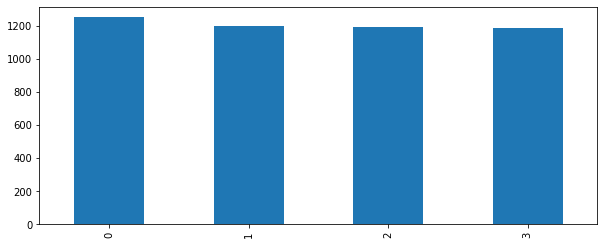

In [83]:
labels = ['3', '2', '1', '0']
plt.figure(figsize=(10,4))
df1['label'].value_counts().plot(kind='bar')

In [84]:
def filter_text(text):
    return None if len(str(text).split()) < 2 else text

print('volume before filter', len(df1))
df1['clean_text'] = df1['clean_text'].apply(filter_text)
df1 = df1.dropna(subset=['clean_text'])
print('volume after filter', len(df1))

volume before filter 4821
volume after filter 4821


In [85]:
# read testing data

df2 = pd.read_excel('testing_2.xlsx')
df2['clean_text'] = df2['text'].apply(clean_text)
df2.head(5)

,text,label,clean_text
0,An earthquake rattled a large swath of Souther...,0,an earthquake rattle a large swath of southern...
1,California earthquake brings scattered damage\...,1,california earthquake brings scatter damage
2,No significant damage or injuries were found i...,1,no significant damage or injury be find in los...
3,earthquake broke my phone :(,1,earthquake break my phone
4,#coppednews Southern California earthquake tri...,2,coppednews southern california earthquake trig...


In [86]:
X_train = df1['clean_text']
y_train = df1['label']
X_test = df2['clean_text']
y_test = df2['label']

### 1. Random Forest + TF-IDF

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(n_estimators=105, max_depth=45, random_state=66)),
              ])
rf = rf.fit(X_train, y_train)

y_trad = rf.predict(X_train)
y_pred = rf.predict(X_test)

print("train accuracy: %.2f%%" % (accuracy_score(y_trad, y_train)*100))
print("test accuracy: %.2f%%" % (accuracy_score(y_pred, y_test)*100))
print(classification_report(y_test, y_pred,target_names=labels))

train accuracy: 99.81%
test accuracy: 84.12%
              precision    recall  f1-score   support

           3       0.75      0.92      0.83       197
           2       0.79      0.53      0.63       136
           1       0.92      0.92      0.92       448
           0       0.44      0.37      0.40        19

    accuracy                           0.84       800
   macro avg       0.72      0.69      0.69       800
weighted avg       0.84      0.84      0.84       800



### 2. Multinomial Bayes + TF-IDF

In [88]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb = nb.fit(X_train, y_train)

y_trad = nb.predict(X_train)
y_pred = nb.predict(X_test)

print("train accuracy: %.2f%%" % (accuracy_score(y_trad, y_train)*100))
print("test accuracy: %.2f%%" % (accuracy_score(y_pred, y_test)*100))
print(classification_report(y_test, y_pred,target_names=labels))

train accuracy: 92.10%
test accuracy: 78.38%
              precision    recall  f1-score   support

           3       0.65      0.87      0.74       197
           2       0.58      0.55      0.56       136
           1       0.94      0.83      0.89       448
           0       0.75      0.32      0.44        19

    accuracy                           0.78       800
   macro avg       0.73      0.64      0.66       800
weighted avg       0.80      0.78      0.79       800



### 3. Support Vector Classification + TF-IDF

In [90]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(penalty='l2', loss='hinge', multi_class='crammer_singer', max_iter=5000))
               ])
svc = svc.fit(X_train, y_train)

y_trad = svc.predict(X_train)
y_pred = svc.predict(X_test)

print("train accuracy: %.2f%%" % (accuracy_score(y_trad, y_train)*100))
print("test accuracy: %.2f%%" % (accuracy_score(y_pred, y_test)*100))
print(classification_report(y_test, y_pred,target_names=labels))

train accuracy: 98.98%
test accuracy: 82.12%
              precision    recall  f1-score   support

           3       0.81      0.85      0.83       197
           2       0.65      0.60      0.63       136
           1       0.91      0.89      0.90       448
           0       0.36      0.53      0.43        19

    accuracy                           0.82       800
   macro avg       0.68      0.72      0.69       800
weighted avg       0.83      0.82      0.82       800



### 4. Logistic Regression (multi-nomial) + TF-IDF

In [91]:
from sklearn.linear_model import LogisticRegression

lr = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver='lbfgs', C=1e5, multi_class='multinomial', max_iter=3000))
               ])
lr = lr.fit(X_train, y_train)

y_trad = lr.predict(X_train)
y_pred = lr.predict(X_test)

print("train accuracy: %.2f%%" % (accuracy_score(y_trad, y_train)*100))
print("test accuracy: %.2f%%" % (accuracy_score(y_pred, y_test)*100))
print(classification_report(y_test, y_pred,target_names=labels))

train accuracy: 99.94%
test accuracy: 81.88%
              precision    recall  f1-score   support

           3       0.82      0.81      0.81       197
           2       0.63      0.55      0.59       136
           1       0.89      0.92      0.90       448
           0       0.38      0.53      0.44        19

    accuracy                           0.82       800
   macro avg       0.68      0.70      0.69       800
weighted avg       0.82      0.82      0.82       800

